In [175]:
import mitdeeplearning as mdl
import gymnasium as gym
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [176]:
environment_name = 'CartPole-v1'

cur_env : gym.Env = gym.make(environment_name)

print(cur_env.action_space.contains)
print(cur_env.observation_space.contains)

<bound method Discrete.contains of Discrete(2)>
<bound method Box.contains of Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)>


In [177]:
episodes = 10
for episode in range(1, episodes+1):
    done = False
    cur_env.reset()
    score = 0

    while not done:
        cur_action = cur_env.action_space.sample()
        n_state, reward, done, info, temp = cur_env.step(cur_action)

        score += reward

    print(f"Episode: {episode}, Score: {score}")


Episode: 1, Score: 25.0
Episode: 2, Score: 15.0
Episode: 3, Score: 12.0
Episode: 4, Score: 17.0
Episode: 5, Score: 14.0
Episode: 6, Score: 72.0
Episode: 7, Score: 48.0
Episode: 8, Score: 12.0
Episode: 9, Score: 21.0
Episode: 10, Score: 25.0


Memory buffer

In [178]:
class Memory:
    def __init__(self):
        self.clear()

    def clear(self):
        self.observations = []
        self.rewards = []
        self.actions = []

    def buffer_result(self, observation, reward, action):
        self.observations.append(observation)
        self.rewards.append(reward)
        self.actions.append(action)

Creating test data with three actions. Each datapoint has two input features x and y, that are normaly distributed.

In [179]:
epochs = 10


dataset_size = 100
n_classes = 3
n_features = 2
ground_truth = np.zeros((2, n_features, n_classes))

In [180]:
def create_feature(is_last, ground_truth, n_features, n_classes, dataset_size, dat_list):
    mean = torch.randint(0, 10, (n_classes,))
    std = np.ones_like(mean)*0.5#torch.rand(n_classes)*2
    ground_truth[0, feature, :] = mean
    ground_truth[1, feature, :] = std

    if (dataset_size // n_classes)*n_classes < dataset_size:
        last_class_size = dataset_size // n_classes + 1
    else:
        last_class_size = dataset_size // n_classes

    class_1 = torch.normal(mean[0].float(), std[0], size=(dataset_size // n_classes, 1))
    class_2 = torch.normal(mean[1].float(), std[1], size=(dataset_size // n_classes, 1))
    class_3 = torch.normal(mean[2].float(), std[2], size=(last_class_size, 1))
    
    if is_last:
        class_1 = torch.concat((class_1, torch.ones_like(class_1)), dim=1)
        class_2 = torch.concat((class_2, torch.ones_like(class_2)*2), dim=1)
        class_3 = torch.concat((class_3, torch.ones_like(class_3)*3), dim=1)


    dat_list.append(torch.concat((class_1, class_2, class_3), dim=0))

dat_list  = []
# Indicates first feature iteration to add the class label column
for feature in range(n_features-1):
    create_feature(False, ground_truth, n_features, n_classes, dataset_size, dat_list)

create_feature(True, ground_truth, n_features, n_classes, dataset_size, dat_list)

dataset = torch.concat(dat_list, dim=1)
dataset.shape

torch.Size([100, 3])

In [181]:
cur_df = pd.DataFrame(dataset.numpy(), columns=["feature_1", "feature_2", "target"])
cur_df

,feature_1,feature_2,target
0,3.668426,3.082209,1.0
1,3.544445,2.269147,1.0
2,4.707748,3.948976,1.0
3,3.536076,3.519657,1.0
4,4.310557,3.636076,1.0
...,...,...,...
95,7.229627,7.512942,3.0
96,7.354663,8.483055,3.0
97,8.616027,8.275340,3.0
98,7.327431,7.277051,3.0


In [182]:
a = cur_df[cur_df["target"] == 1]["feature_1"].values
b = cur_df[cur_df["target"] == 1]["feature_2"].values
c = cur_df[cur_df["target"] == 2]["feature_1"].values
d = cur_df[cur_df["target"] == 2]["feature_2"].values
e = cur_df[cur_df["target"] == 3]["feature_1"].values
f = cur_df[cur_df["target"] == 3]["feature_2"].values

Text(0, 0.5, 'feature_2')

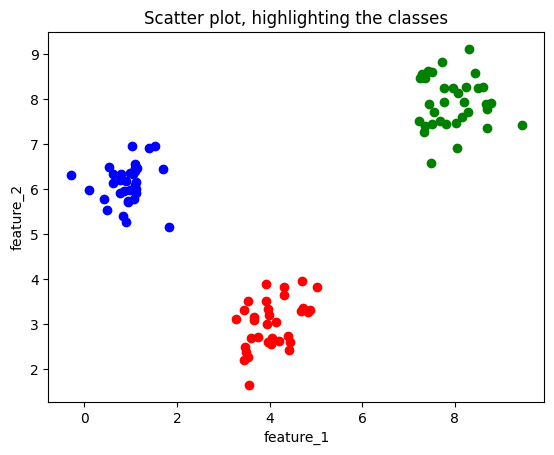

In [183]:
plt.title("Scatter plot, highlighting the classes")
plt.scatter(a,b, c="red")
plt.scatter(c,d, c="blue")
plt.scatter(e,f, c="green")
plt.xlabel("feature_1")
plt.ylabel("feature_2")

Splitting dataset and shuffeling

In [184]:
dataset[:, :]

tensor([[ 3.6684,  3.0822,  1.0000],
        [ 3.5444,  2.2691,  1.0000],
        [ 4.7077,  3.9490,  1.0000],
        [ 3.5361,  3.5197,  1.0000],
        [ 4.3106,  3.6361,  1.0000],
        [ 3.9971,  3.2038,  1.0000],
        [ 4.0530,  2.6789,  1.0000],
        [ 3.4381,  2.1858,  1.0000],
        [ 4.8269,  3.2614,  1.0000],
        [ 5.0328,  3.8206,  1.0000],
        [ 4.3131,  3.8233,  1.0000],
        [ 4.2079,  2.6285,  1.0000],
        [ 3.9596,  3.3258,  1.0000],
        [ 3.4804,  2.4969,  1.0000],
        [ 3.4388,  3.3190,  1.0000],
        [ 3.9405,  3.0007,  1.0000],
        [ 3.7474,  2.7012,  1.0000],
        [ 3.9326,  3.5065,  1.0000],
        [ 3.2689,  3.1053,  1.0000],
        [ 3.9611,  2.5918,  1.0000],
        [ 4.0393,  2.5561,  1.0000],
        [ 4.3970,  2.7260,  1.0000],
        [ 4.6863,  3.2895,  1.0000],
        [ 3.9333,  3.8818,  1.0000],
        [ 4.1423,  3.0333,  1.0000],
        [ 4.4305,  2.4194,  1.0000],
        [ 4.4345,  2.6074,  1.0000],
 

In [185]:
class test_dataset(Dataset):
    def __init__(self, raw_dataset):
        self.dataset = raw_dataset
        
    def __len__(self):
        return self.dataset.shape[0]

    def __getitem__(self, idx):
        return self.dataset[idx,:-1], self.dataset[idx, -1]

In [186]:
torch_d = test_dataset(dataset)
train_d, val_d, test_d = torch.utils.data.random_split(torch_d, [0.6, 0.2, 0.2])

In [187]:
# Add DataLoaders
train_loader = DataLoader(train_d, batch_size=10, shuffle=True)
val_loader = DataLoader(val_d, batch_size=10, shuffle=True)
#test_loader = DataLoader(test_d, batch_size=10, shuffle=True)

In [192]:
class PolicyModel(nn.Module):
    def __init__(self, in_features, out_features, device):
        super().__init__()
        self.hidden_layers = nn.Sequential(
            nn.Linear(in_features, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, out_features)
        ).to(device)

    def forward(self, input):
        logits = self.hidden_layers(input)
        return logits#nn.Softmax(logits)


cur_policy = PolicyModel(n_features, n_classes, device)
optimizer = torch.optim.Adam(params=cur_policy.parameters())
loss_func = torch.nn.CrossEntropyLoss()

# For each epoch
cur_policy.train()
for epoch in range(epochs):
    # Iterate over mini-batches
    n_train_batches = len(train_loader.dataset)
    print(n_train_batches)
    for batch, (X, Y) in enumerate(train_loader):
        # Make the forward pass
        predicted = cur_policy(X)
        # Calculate loss
        loss = loss_func(predicted, Y.long()-1)
        # Make back propagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 10 == 0:
            print(f"Epoch: {epoch}, mini-batch: {batch}, loss: {loss.detach()}")

    # Make evaluation at the end of epoch
    cur_policy.eval()
    size = len(val_loader.dataset)
    n_batch = len(val_loader)
    val_loss = 0
    correct_classified = 0


    with torch.inference_mode():
        for X, Y in val_loader:
            pred = cur_policy(X)    
            val_loss += loss_func(pred, Y.long()-1).item()
            correct_classified += (pred.argmax(1) == Y.long()-1).type(torch.float).sum().item()

    val_loss /= n_batch
    correct_classified /= size
    print(f"Test Error: \n Accuracy: {(100*correct_classified):>0.1f}%, Avg loss: {val_loss:>8f} \n")
        


60
Epoch: 0, mini-batch: 0, loss: 1.2375308275222778
Test Error: 
 Accuracy: 25.0%, Avg loss: 0.993791 

60
Epoch: 1, mini-batch: 0, loss: 0.8377594947814941
Test Error: 
 Accuracy: 60.0%, Avg loss: 0.804761 

60
Epoch: 2, mini-batch: 0, loss: 0.789564847946167
Test Error: 
 Accuracy: 80.0%, Avg loss: 0.632761 

60
Epoch: 3, mini-batch: 0, loss: 0.7623162865638733
Test Error: 
 Accuracy: 75.0%, Avg loss: 0.532156 

60
Epoch: 4, mini-batch: 0, loss: 0.43611472845077515
Test Error: 
 Accuracy: 75.0%, Avg loss: 0.480905 

60
Epoch: 5, mini-batch: 0, loss: 0.2731495797634125
Test Error: 
 Accuracy: 85.0%, Avg loss: 0.396577 

60
Epoch: 6, mini-batch: 0, loss: 0.3416258692741394
Test Error: 
 Accuracy: 95.0%, Avg loss: 0.336360 

60
Epoch: 7, mini-batch: 0, loss: 0.43045514822006226
Test Error: 
 Accuracy: 90.0%, Avg loss: 0.302967 

60
Epoch: 8, mini-batch: 0, loss: 0.3928568959236145
Test Error: 
 Accuracy: 90.0%, Avg loss: 0.277344 

60
Epoch: 9, mini-batch: 0, loss: 0.16347207129001617
